# Introduction

I have been wondered how to understand do-calculus in pyro. CEVAE is great but it's a fully functional big model, not a toy one to tweak and play. Until I find a really great blog post: https://www.inference.vc/causal-inference-2-illustrating-interventions-in-a-toy-example/ 

In this notebook I'm trying to implement in pyro to show how x and y variables behave when we put condition and do-calculus on it (include after we train). 

Have to note that I don't know using do-calculus before training is a proper way or not, because in CEVAE example we use do-calculus after training.

# Define helper function

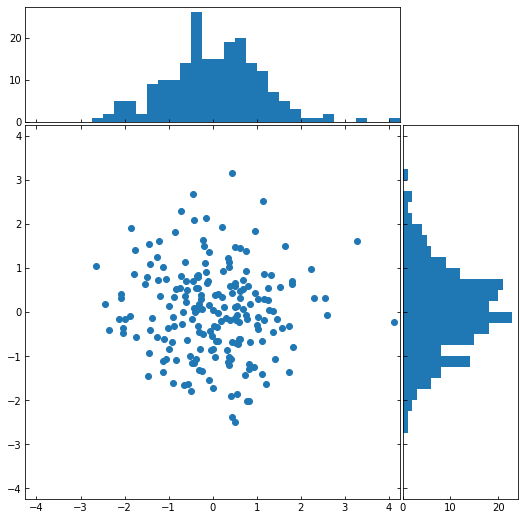

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def fancy_plot(x,y):
  # definitions for the axes
  left, width = 0.1, 0.65
  bottom, height = 0.1, 0.65
  spacing = 0.005


  rect_scatter = [left, bottom, width, height]
  rect_histx = [left, bottom + height + spacing, width, 0.2]
  rect_histy = [left + width + spacing, bottom, 0.2, height]

  # start with a rectangular Figure
  plt.figure(figsize=(8, 8))

  ax_scatter = plt.axes(rect_scatter)
  ax_scatter.tick_params(direction='in', top=True, right=True)
  ax_histx = plt.axes(rect_histx)
  ax_histx.tick_params(direction='in', labelbottom=False)
  ax_histy = plt.axes(rect_histy)
  ax_histy.tick_params(direction='in', labelleft=False)

  # the scatter plot:
  ax_scatter.scatter(x, y)

  # now determine nice limits by hand:
  binwidth = 0.25
  lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
  ax_scatter.set_xlim((-lim, lim))
  ax_scatter.set_ylim((-lim, lim))

  bins = np.arange(-lim, lim + binwidth, binwidth)
  ax_histx.hist(x, bins=bins)
  ax_histy.hist(y, bins=bins, orientation='horizontal')

  ax_histx.set_xlim(ax_scatter.get_xlim())
  ax_histy.set_ylim(ax_scatter.get_ylim())

fancy_plot(np.random.randn(200), np.random.randn(200))

In [0]:
def genNsample(script, N=500, pyro = False):
  x,y=[],[]
  for i in range(N):
    x_tmp,y_tmp = script()
    if pyro:
      x_tmp = x_tmp.numpy()
      y_tmp = y_tmp.numpy()
    x.append(x_tmp)
    y.append(y_tmp)
  fancy_plot(x,y)
  return x,y

# 3 Script from blog post

In [0]:
randn = np.random.randn
sqrt = np.sqrt

In [0]:
def script1():
  x= randn()
  y = x+1 + sqrt(3)*randn()
  return x,y
script1()

(-0.8831255611139024, 2.7935629396829675)

In [0]:
def script2():
  y= 1 + 2 * randn()
  x = (y-1)/4 + sqrt(3) * randn()/2
  return x,y
script2()

(-0.2735819725453198, 1.2916801462876426)

In [0]:
def script3(get_z = False):
  z = randn()
  y = z+1+sqrt(3)*randn()
  x=z
  if get_z == True:
    return x,y,z
  else:
    return x,y

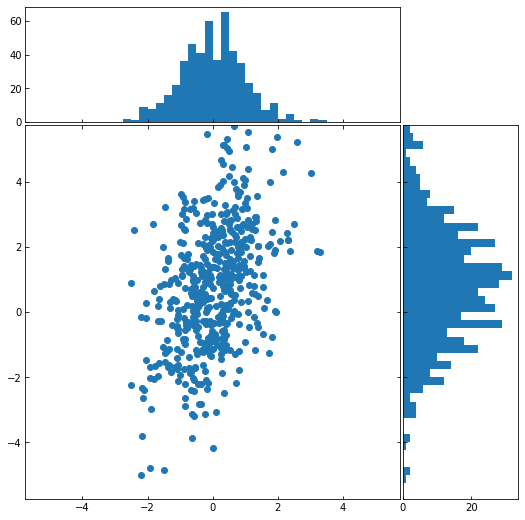

In [0]:
_,_ = genNsample(script1)

In [0]:
def script1_fix():
  x= randn()
  x=3
  y = x+1 + sqrt(3)*randn()
  x=3
  return x,y
script1()

(-0.5857569978541174, -3.137168675327734)

In [0]:
def script2_fix():
  y= 1 + 2 * randn()
  x=3
  x = (y-1)/4 + sqrt(3) * randn()/2
  x=3
  return x,y
script2()

(-0.2123119539084536, -2.3338605862994957)

In [0]:
def script3_fix(get_z = False):
  z = randn()
  x=3
  y = z+1+sqrt(3)*randn()
  x=3
  x=z
  x=3
  if get_z == True:
    return x,y,z
  else:
    return x,y

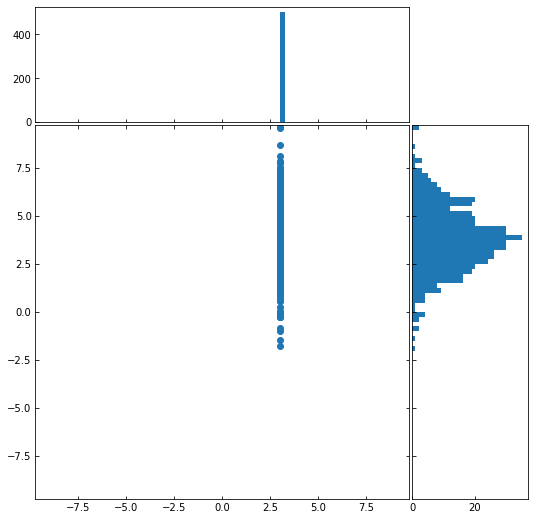

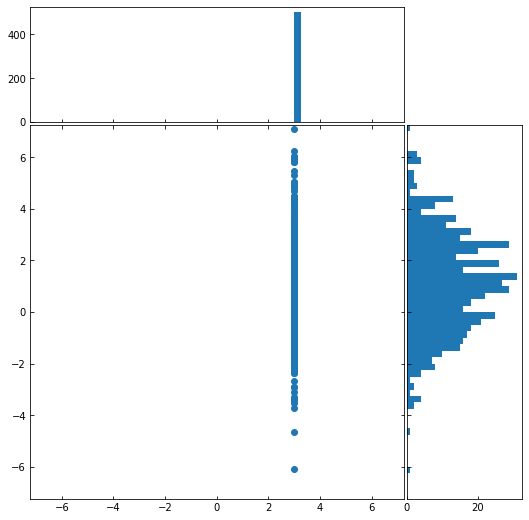

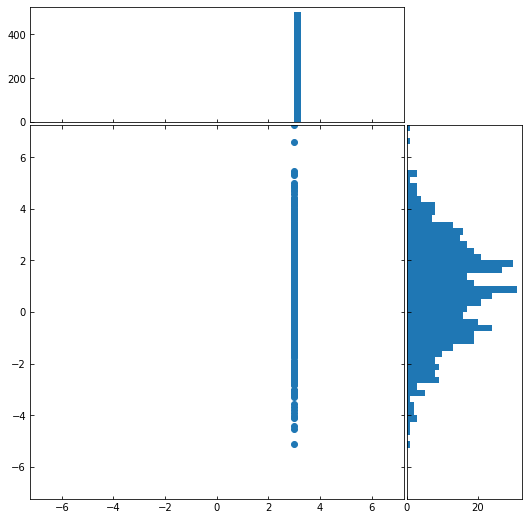

In [0]:
s1,s2,s3 = genNsample(script1_fix),genNsample(script2_fix),genNsample(script3_fix)

# In pyro

In [0]:
%%capture
!pip install pyro-ppl 

In [0]:
import torch
from torch.distributions import constraints

# Pyro
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
pyro.enable_validation(True)    # <---- This is always a good idea!

The problem here is how we gonna define x and y, I choose to replace randn() in the example with a constant. 

If we choose to keep randn(), it will be 2 time randomness. If we replace randn() with pyro sample, then x and y only a normal distribution (0,1), not really a thing I understand in the example. So I choose the above option.

In [0]:
def model1():
  x = pyro.sample('x1', dist.Normal(0,1))
  y = pyro.sample('y1', dist.Normal(x+1+sqrt(3)*0.1,1))
  return x,y
model1()

(tensor(0.2729), tensor(0.6415))

In [0]:
def model2():
    y = pyro.sample('y2', dist.Normal(1 + 2 * 0.1,1))
    x =   pyro.sample('x2', dist.Normal((y-1)/4 + sqrt(3) * 0.1/2,1))
    return x,y
model2()

(tensor(0.1084), tensor(1.0622))

In [0]:
def model3(get_z = False):
  z = pyro.sample('z3', dist.Normal(0,1))
  y =pyro.sample('y3', dist.Normal( z+1+sqrt(3)*0.1,1))
  x=pyro.sample('x3', dist.Normal(z,1))
  if get_z == True:
    return x,y,z
  else:
    return x,y
model3()

(tensor(0.5504), tensor(0.9349))

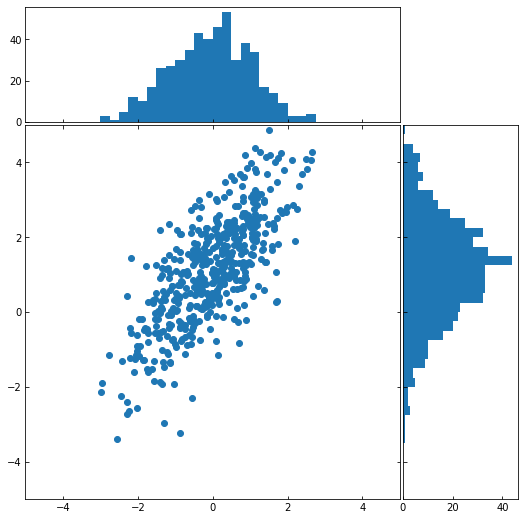

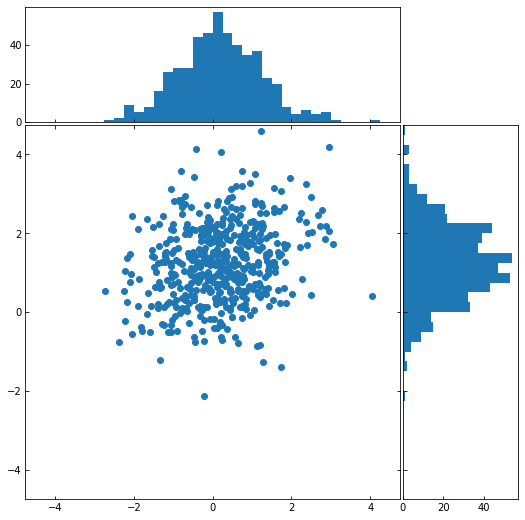

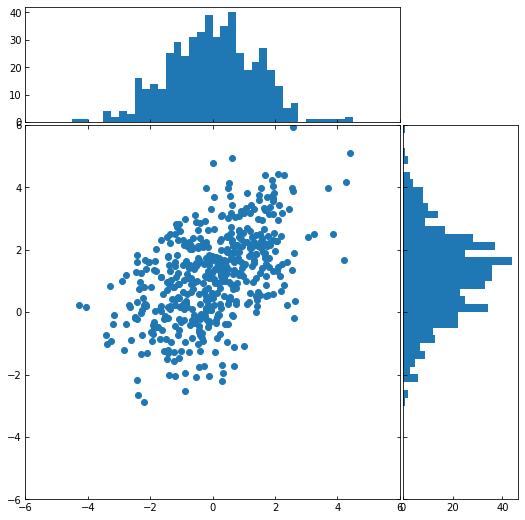

In [0]:
_ = genNsample(model1,pyro=True),genNsample(model2,pyro=True),genNsample(model3,pyro=True)

In [0]:
cond1 = pyro.condition(model1,data={'x1':torch.tensor(3.)})
cond2 = pyro.condition(model2,data={'x2':torch.tensor(3.)})
cond3 = pyro.condition(model3,data={'x3':torch.tensor(3.)})
do1 = pyro.do(model1, data={'x1':torch.tensor(3.)})
do2 = pyro.do(model2, data={'x2':torch.tensor(3.)})
do3 = pyro.do(model3, data={'x3':torch.tensor(3.)})

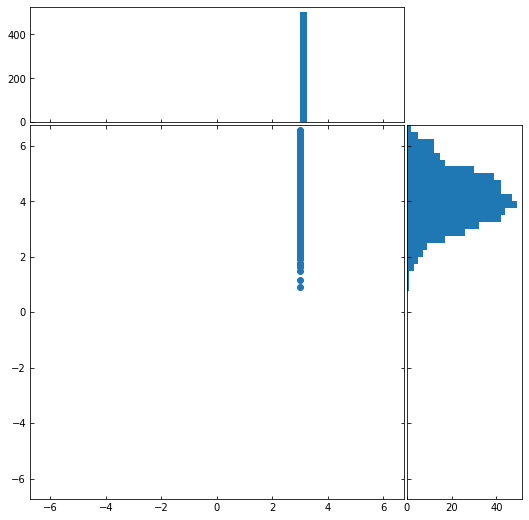

In [0]:
pyro.clear_param_store()
_ = genNsample(cond1,pyro=True)

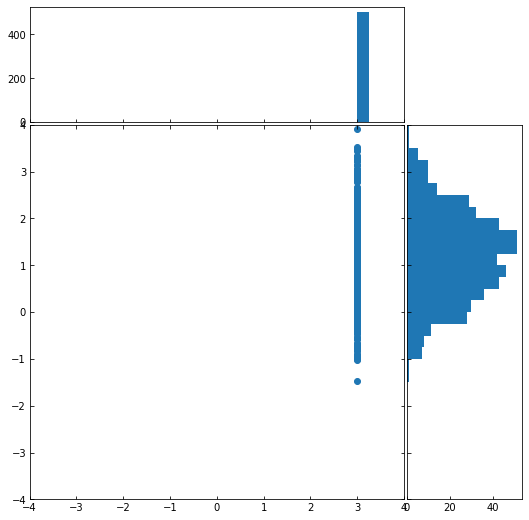

In [0]:
_ = genNsample(cond2,pyro=True)

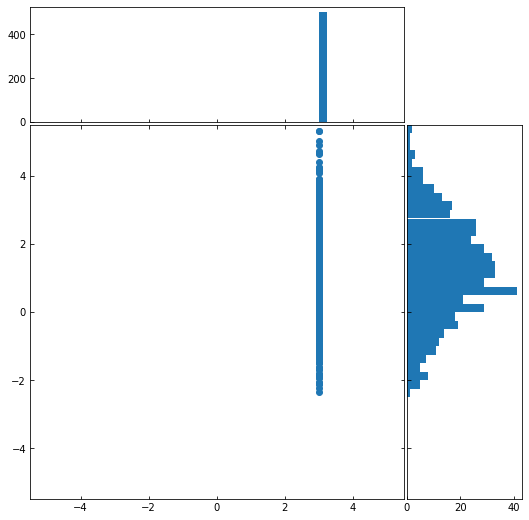

In [0]:
_ = genNsample(cond3,pyro=True)

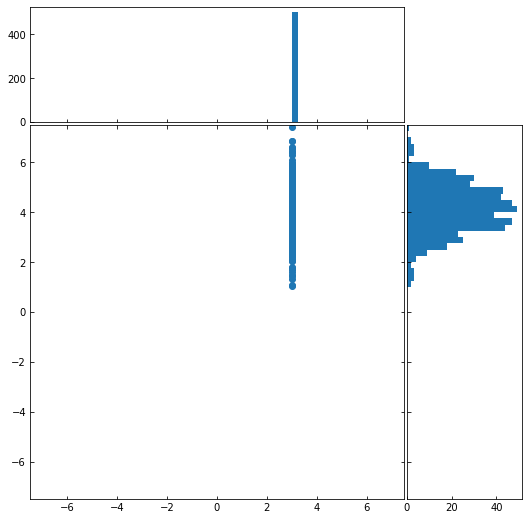

In [0]:
_ = genNsample(do1,pyro=True)

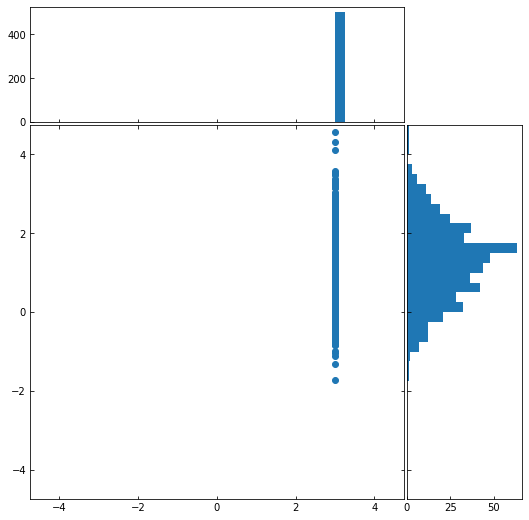

In [0]:
_ = genNsample(do2,pyro=True)

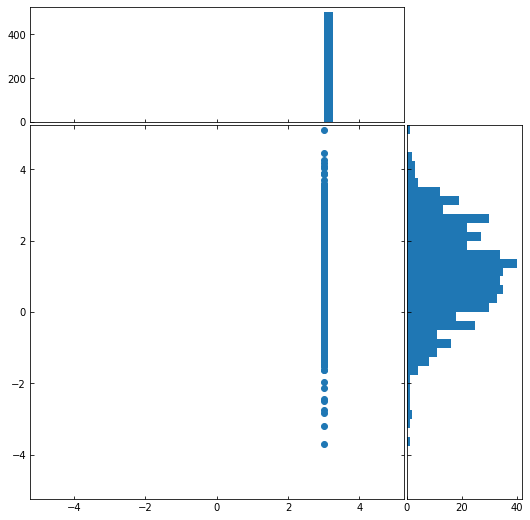

In [0]:
_ = genNsample(do3,pyro=True)

In [0]:
from pyro.infer import Predictive

In [0]:
prior = Predictive(cond2, num_samples=500).get_samples()

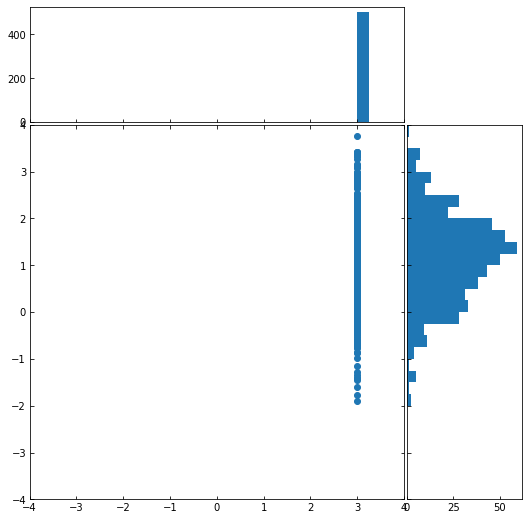

In [0]:
fancy_plot(prior['x2'].numpy(), prior['y2'].numpy())

# Prior condition look the same as do-calculus, what about training to find posterior

In [0]:
from pyro.infer import SVI, JitTrace_ELBO

In [0]:
def train(model, guide,i):
  pyro.clear_param_store()
  adam = pyro.optim.Adam({"lr": 0.005})
  svi = SVI(model, guide, adam, loss=JitTrace_ELBO())
  for j in range(1000):
      # calculate the loss and take a gradient step
      loss = svi.step()
      if j % 100 == 0:
          print("[iteration %04d] loss: %.4f" % (j + 1, loss))
  predictive = Predictive(model,guide = guide,num_samples=600).get_samples()
  # fancy_plot(predictive['x{}'.format(i)].detach().numpy(), predictive['y{}'.format(i)].detach().numpy())
  return predictive['y{}'.format(i)].detach().numpy()

In [0]:
def guide3_cond(get_z = False):
  loc = pyro.param('loc', torch.tensor(0.))
  std = pyro.param('std', torch.tensor(1.))
  stdy = pyro.param('stdy', torch.tensor(1.))
  z = pyro.sample('z3', dist.Normal(loc,std))
  y =pyro.sample('y3', dist.Normal( z+1+sqrt(3)*0.1,stdy))
  

In [0]:
def guide2_cond():
  loc = pyro.param('loc', torch.tensor(0.))
  std = pyro.param('std', torch.tensor(1.))
  y = pyro.sample('y2', dist.Normal(loc,std))
  

In [0]:
def guide1_cond():
  std = pyro.param('std', torch.tensor(1.))
  y = pyro.sample('y1', dist.Normal(3+1+sqrt(3)*0.1,std))

In [0]:
def guide3_do(get_z = False):
  loc = pyro.param('loc', torch.tensor(0.))
  std = pyro.param('std', torch.tensor(1.))
  stdy = pyro.param('stdy', torch.tensor(1.))
  z = pyro.sample('z3', dist.Normal(loc,std))
  y =pyro.sample('y3', dist.Normal( z+1+sqrt(3)*0.1,stdy))
  

In [0]:
def guide2_do():
  loc = pyro.param('loc', torch.tensor(0.))
  std = pyro.param('std', torch.tensor(1.))
  y = pyro.sample('y2', dist.Normal(loc,std))

In [0]:
def guide1_do():
  loc = torch.tensor(3.) + 1 + sqrt(3)*0.1
  std = pyro.param('std', torch.tensor(1.))
  y = pyro.sample('y1', dist.Normal(loc,std))

In [0]:
d1 = train(cond1,guide1_cond,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  


[iteration 0001] loss: 5.4189
[iteration 0101] loss: 5.4427
[iteration 0201] loss: 5.4508
[iteration 0301] loss: 5.4109
[iteration 0401] loss: 5.3932
[iteration 0501] loss: 5.4167
[iteration 0601] loss: 5.3834
[iteration 0701] loss: 5.4312
[iteration 0801] loss: 5.4327
[iteration 0901] loss: 5.3774


In [0]:
d2 = train(cond2,guide2_cond,2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until


[iteration 0001] loss: 9.7203
[iteration 0101] loss: 4.7929
[iteration 0201] loss: 4.4746
[iteration 0301] loss: 4.7100
[iteration 0401] loss: 5.8619
[iteration 0501] loss: 5.1630
[iteration 0601] loss: 4.9320
[iteration 0701] loss: 5.0499
[iteration 0801] loss: 5.0812
[iteration 0901] loss: 4.7348


In [0]:
d3 = train(cond3,guide3_cond,3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if y

[iteration 0001] loss: 2.6318
[iteration 0101] loss: 5.2974
[iteration 0201] loss: 5.9012
[iteration 0301] loss: 2.6682
[iteration 0401] loss: 4.0051
[iteration 0501] loss: 4.3898
[iteration 0601] loss: 3.7410
[iteration 0701] loss: 3.4586
[iteration 0801] loss: 3.5413
[iteration 0901] loss: 3.5396


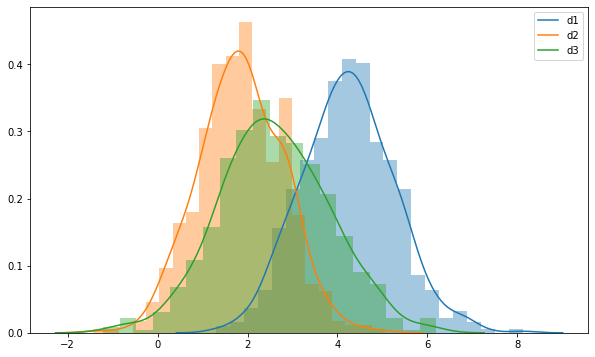

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
sns.distplot(d1,kde_kws={'label':'d1'})
sns.distplot(d2,kde_kws={'label':'d2'})
sns.distplot(d3,kde_kws={'label':'d3'})

In [0]:
d1 = train(do1,guide1_do,1)

/usr/local/lib/python3.6/dist-packages/pyro/util.py:210: UserWarning: Found vars in model but not guide: {'x1'}
  warnings.warn("Found vars in model but not guide: {}".format(model_vars - guide_vars - enum_vars))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so w

[iteration 0001] loss: 1.7924
[iteration 0101] loss: 3.3224
[iteration 0201] loss: 6.8599
[iteration 0301] loss: 2.1572
[iteration 0401] loss: 0.7807
[iteration 0501] loss: 1.6186
[iteration 0601] loss: 1.1647
[iteration 0701] loss: 1.3536
[iteration 0801] loss: 1.5879
[iteration 0901] loss: 1.1324


In [0]:
d2 = train(do2,guide2_do,2)

/usr/local/lib/python3.6/dist-packages/pyro/util.py:210: UserWarning: Found vars in model but not guide: {'x2'}
  warnings.warn("Found vars in model but not guide: {}".format(model_vars - guide_vars - enum_vars))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so w

[iteration 0001] loss: 2.0902
[iteration 0101] loss: 1.1586
[iteration 0201] loss: 2.3342
[iteration 0301] loss: 1.3011
[iteration 0401] loss: 0.9741
[iteration 0501] loss: 0.5021
[iteration 0601] loss: 1.2563
[iteration 0701] loss: 1.8308
[iteration 0801] loss: 0.9285
[iteration 0901] loss: 0.9035


In [0]:
d3 = train(do3,guide3_do,3)

/usr/local/lib/python3.6/dist-packages/pyro/util.py:210: UserWarning: Found vars in model but not guide: {'x3'}
  warnings.warn("Found vars in model but not guide: {}".format(model_vars - guide_vars - enum_vars))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so w

[iteration 0001] loss: 0.9193
[iteration 0101] loss: 1.5576
[iteration 0201] loss: 1.3904
[iteration 0301] loss: 1.1679
[iteration 0401] loss: 1.5906
[iteration 0501] loss: 1.5235
[iteration 0601] loss: 3.1349
[iteration 0701] loss: 1.0305
[iteration 0801] loss: 1.0582
[iteration 0901] loss: 1.1147


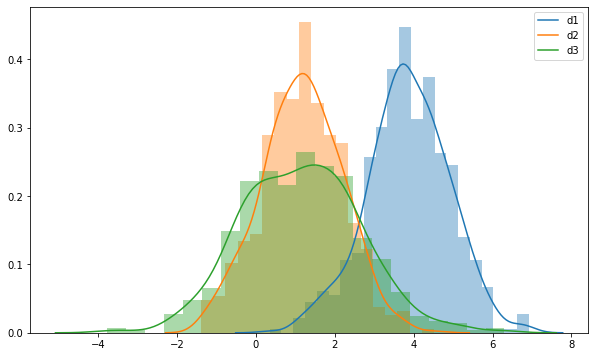

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
sns.distplot(d1,kde_kws={'label':'d1'})
sns.distplot(d2,kde_kws={'label':'d2'})
sns.distplot(d3,kde_kws={'label':'d3'})

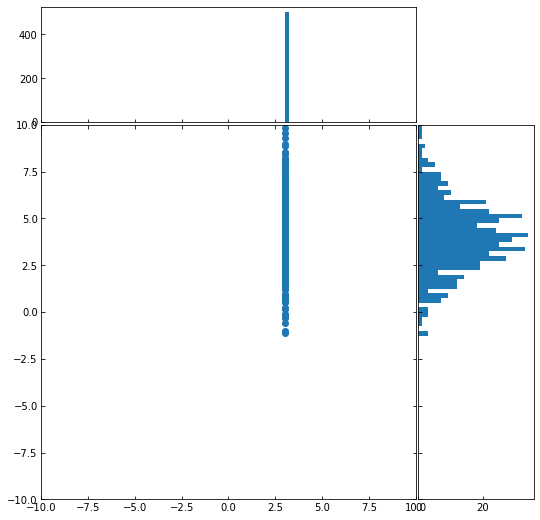

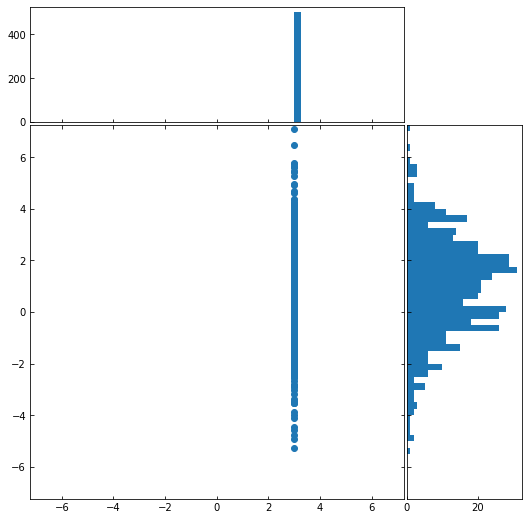

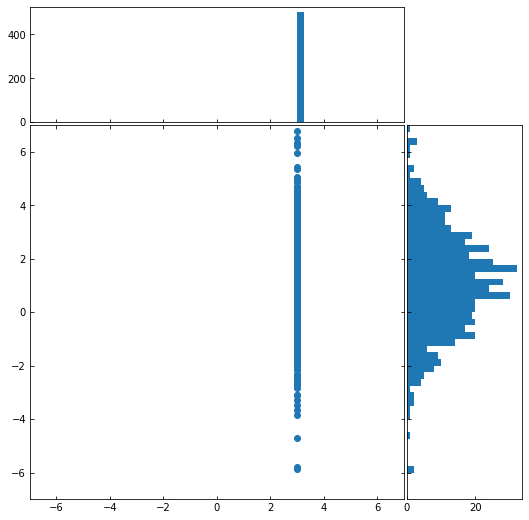

In [0]:
_,d1 = genNsample(script1_fix)
_,d2 = genNsample(script2_fix)
_,d3 = genNsample(script3_fix)

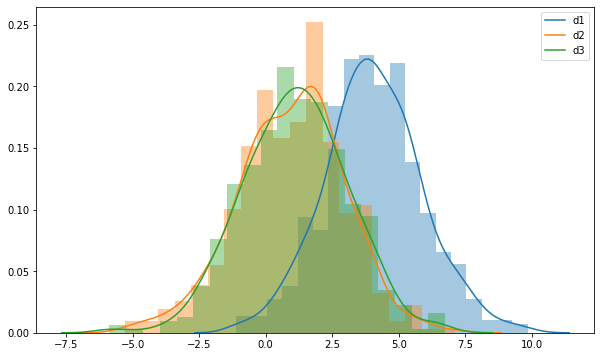

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
sns.distplot(d1,kde_kws={'label':'d1'})
sns.distplot(d2,kde_kws={'label':'d2'})
sns.distplot(d3,kde_kws={'label':'d3'})

# MCMC (draft)


In [0]:
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
 
pyro.set_rng_seed(2)



In [0]:
def domcmc(model):
  kernel = NUTS(model,jit_compile=True, ignore_jit_warnings=True)
  mcmc = MCMC(kernel, num_samples=100, warmup_steps=400)
  mcmc.run()
  mcmc.summary()

In [0]:
domcmc(cond1)
domcmc(cond2)
domcmc(cond3)

Warmup:   4%|▍         | 20/500 [00:00, 199.95it/s, step size=2.04e+00, acc. prob=0.762]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        y1      4.55      1.14      4.69      2.98      6.84     39.11      0.99

Number of divergences: 0


Warmup:   2%|▏         | 8/500 [00:00, 76.26it/s, step size=2.23e-01, acc. prob=0.621]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        y2      1.88      0.96      1.86      0.29      3.44     26.64      1.13

Number of divergences: 0


Sample: 100%|██████████| 500/500 [00:03, 163.02it/s, step size=7.08e-01, acc. prob=0.898]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        z3      1.31      0.58      1.25      0.51      2.27     61.98      1.02
        y3      2.34      1.05      2.27      0.77      4.02     61.85      1.00

Number of divergences: 0


In [0]:
domcmc(do1)
domcmc(do2)
domcmc(do3)

Warmup:   2%|▏         | 9/500 [00:00, 84.22it/s, step size=2.58e-01, acc. prob=0.647]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1     -0.01      0.98     -0.06     -1.54      1.67    101.22      1.00
        y1      4.24      0.94      4.12      2.68      5.72     66.81      0.99

Number of divergences: 0


Warmup:   2%|▏         | 8/500 [00:00, 57.05it/s, step size=1.56e-01, acc. prob=0.607]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        y2      1.24      1.18      1.19     -0.30      3.63    100.36      0.99
        x2      0.01      1.11      0.01     -1.89      1.50    121.06      0.99

Number of divergences: 0


Sample: 100%|██████████| 500/500 [00:05, 95.57it/s, step size=4.26e-01, acc. prob=0.919]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        z3     -0.03      1.01      0.01     -1.68      1.78     46.85      1.06
        y3      1.15      1.42      1.11     -1.23      3.29     57.74      1.01
        x3      0.05      1.37      0.03     -2.21      2.13     46.02      1.08

Number of divergences: 0
